In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os, glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


2025-08-30 23:19:10.887493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756595951.057198      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756595951.104138      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**This notebook was created on kaggle. Make sure the dataset Adience Preprocessed from geekjr is added as input already in kaggle.**

In [2]:
# Config


DATASET_PATH = "/kaggle/input/adience-dataset-preprocessed/datasets/age"
IMG_HEIGHT, IMG_WIDTH = 160, 160
BATCH_SIZE = 32
EPOCHS = 20
TEST_SPLIT = 0.2  # 20% test set

In [3]:
# for creating train and test dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=TEST_SPLIT,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=TEST_SPLIT,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names) # just to make sure i got it right

Found 11030 files belonging to 8 classes.
Using 8824 files for training.


I0000 00:00:1756595968.461688      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756595968.462500      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 11030 files belonging to 8 classes.
Using 2206 files for validation.
Classes: ['0-3', '15-23', '25-36', '38-48', '4-6', '48-58', '60-100', '8-13']


In [4]:
# some tuning for performance since the first ran didn't do well
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# constructing model (same over MobileNetV2)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze backbone

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# training and saving model

history = model.fit(train_ds, epochs=EPOCHS)

# Save model
model.save("age_model_adience_preprocessed.h5")
print("Model saved as age_model_adience_preprocessed.h5")

# Also as tflite
loaded = tf.keras.models.load_model("/kaggle/working/age_model_adience_preprocessed.h5")  
converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_from_h5 = converter.convert()
open("age_model_adience_preprocessed.tflite", "wb").write(tflite_from_h5)
print("Saved age_model_adience_preprocessed.tflite")

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.4202 - loss: 1.5241
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4207 - loss: 1.4989
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4226 - loss: 1.5091
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4193 - loss: 1.5003
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.4246 - loss: 1.4846
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.4247 - loss: 1.4935
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.4270 - loss: 1.4871
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4306 - loss: 1.4776
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4219 - loss: 1.4673
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.4337 - loss: 1.4619
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.4317 - loss: 1.4608
Epoch 12/20
276/276 ━━━━━━━━━━

W0000 00:00:1756596888.498537      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756596888.498576      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1756596888.652384      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


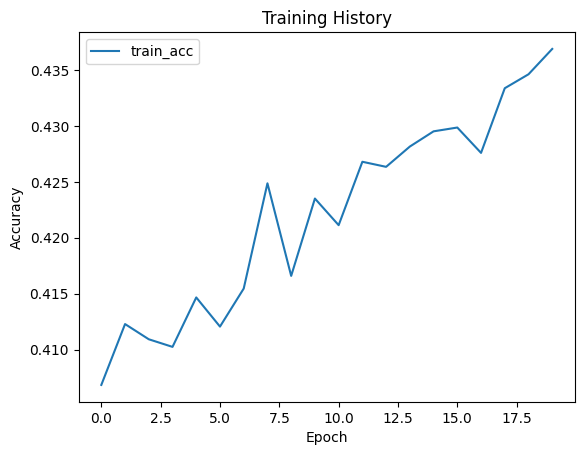


--- Evaluating on Test Set ---
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step

Classification Report:
              precision    recall  f1-score   support

         0-3       0.18      0.14      0.15       362
       15-23       0.02      0.01      0.01       176
       25-36       0.27      0.61      0.37       597
       38-48       0.15      0.06      0.09       303
         4-6       0.15      0.13      0.14       296
       48-58       0.00      0.00      0.00       118
      60-100       0.00      0.00      0.00        91
        8-13       0.14      0.07      0.09       263

    accuracy                           0.22      2206
   macro avg       0.11      0.13      0.11      2206
weighted avg       0.16      0.22      0.17      2206



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# plot training and evaluation
def plot_history(hist):
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training History")
    plt.show()

plot_history(history)

# evaluate on Test set 
print("\n--- Evaluating on Test Set ---")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


**Since the results are obviously not that good, I am going to do some more fine-tuning and transfer learning off the newly learned layers from the Adience model and use it to learn age data from UTKFace model as well in hope to improve it.**

**Also, I noticed the dataset is imbalanced in both of the models so I am going to merge the age bins into smaller groups to counter the imbalance dataset and avoid overfitting on specific age groups.**

In [22]:
# FINE-TUNING THE ADIENCE MODEL ON THE UTKFACE DATASET (MERGED BINS)

# Config

UTKFACE_PATH = "/kaggle/input/utkface-new/UTKFace"
ADIENCE_MODEL_PATH = "/kaggle/working/age_model_adience_preprocessed.h5"
IMG_HEIGHT, IMG_WIDTH = 160, 160
BATCH_SIZE = 32
EPOCHS_FINETUNE = 20

# New merged bins
MERGED_BINS = [(0, 12), (13, 20), (21, 32), (33, 53), (54, 120)]
MERGED_BIN_LABELS = ["Child (0-12)", "Teen (13-20)", "Young Adult (21-32)", 
                     "Adult (33-53)", "Senior (54+)"]
NUM_AGE_CLASSES = len(MERGED_BINS)

In [23]:
# Map ages into bins
def age_to_merged_bin(age):
    for i, (start, end) in enumerate(MERGED_BINS):
        if start <= age <= end:
            return i
    return None

In [24]:
# Load UTKFace paths + labels
def get_utk_paths_and_labels():
    paths, labels = [], []
    for filename in os.listdir(UTKFACE_PATH):
        try:
            parts = filename.split("_")
            if parts[0].isdigit():
                age = int(parts[0])
                age_bin = age_to_merged_bin(age)
                if age_bin is not None:
                    paths.append(os.path.join(UTKFACE_PATH, filename))
                    labels.append(age_bin)
        except:
            continue
    print(f"✅ Loaded {len(paths)} UTKFace samples mapped to merged bins.")
    return paths, labels

In [25]:
# Dataset creation 
def parse_image_age(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, NUM_AGE_CLASSES)
    return image, label

def create_dataset(paths, labels, batch_size=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(parse_image_age, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# load UTKFace dataset 
paths, labels = get_utk_paths_and_labels()

✅ Loaded 23708 UTKFace samples mapped to merged bins.


In [26]:
# Train/Val/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    paths, labels, test_size=0.2, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Data split -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

train_ds = create_dataset(X_train, y_train, shuffle=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

Data split -> Train: 14224, Val: 4742, Test: 4742


In [27]:
# looad Adience model for fine-tuning 
if not os.path.exists(ADIENCE_MODEL_PATH):
    raise FileNotFoundError("Adience model not found. Please train it first (duh).")

base_model = tf.keras.models.load_model(ADIENCE_MODEL_PATH)

In [28]:
# take base featere extractor (without classifier head)
feature_extractor = base_model.layers[0]
feature_extractor.trainable = True
for layer in feature_extractor.layers[:-20]:
    layer.trainable = False

# build new model with new classifier
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = feature_extractor(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_AGE_CLASSES, activation="softmax")(x)
age_model_finetune = tf.keras.Model(inputs, outputs)

In [29]:
# Compile with very low LR
age_model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
# Fine-tuning
history_finetune = age_model_finetune.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE
)

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 64s 101ms/step - accuracy: 0.3388 - loss: 1.6260 - val_accuracy: 0.5207 - val_loss: 1.1556
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.5457 - loss: 1.1075 - val_accuracy: 0.5827 - val_loss: 1.0504
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.5906 - loss: 0.9941 - val_accuracy: 0.6046 - val_loss: 0.9761
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6235 - loss: 0.9272 - val_accuracy: 0.6215 - val_loss: 0.9333
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6456 - loss: 0.8769 - val_accuracy: 0.6326 - val_loss: 0.8949
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6555 - loss: 0.8527 - val_accuracy: 0.6455 - val_loss: 0.8700
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6674 - loss: 0.8154 - val_accuracy: 0.6514 - val_loss: 0.8550
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6858 - loss: 0.7796 -

In [31]:
#  Save fine-tuned model 
age_model_finetune.save("age_model_finetuned_utkface_mergedbins.h5")
print("💾 Fine-tuned model saved as age_model_finetuned_utkface_mergedbins.h5")

# also as tflite
loaded = tf.keras.models.load_model("/kaggle/working/age_model_finetuned_utkface_mergedbins.h5")  
converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_from_h5 = converter.convert()
open("age_model_finetuned_utkface_mergedbins.tflite", "wb").write(tflite_from_h5)
print("Saved age_model_finetuned_utkface_mergedbins.tflite")


💾 Fine-tuned model saved as age_model_finetuned_utkface_mergedbins.h5
Saved artifact at '/tmp/tmpymsn26e1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133899129038480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129037136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129036752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129037328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129037520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129036176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129032528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133893803389392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133899129035600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1338991290350

W0000 00:00:1756597546.466445      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756597546.466487      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [32]:
# Evaluation
print("\n--- Evaluating Fine-Tuned Model on UTKFace Test Set ---")
y_pred_probs = age_model_finetune.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_one_hot = np.concatenate([y for _, y in test_ds], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)

print(classification_report(y_true, y_pred, target_names=MERGED_BIN_LABELS))


--- Evaluating Fine-Tuned Model on UTKFace Test Set ---
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step
                     precision    recall  f1-score   support

       Child (0-12)       0.88      0.88      0.88       683
       Teen (13-20)       0.55      0.20      0.29       293
Young Adult (21-32)       0.65      0.85      0.74      1760
      Adult (33-53)       0.57      0.44      0.49      1207
       Senior (54+)       0.76      0.70      0.73       799

           accuracy                           0.68      4742
          macro avg       0.68      0.61      0.63      4742
       weighted avg       0.68      0.68      0.67      4742

